In [1]:

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az
import pytensor.tensor as tt

rng = np.random.default_rng(1331)

In [2]:
pxi_df = pd.read_csv(r"data/pxi_results.csv")

pxi_df

participant_id   game_name  trial  mode  difficulty             pxi_AA  \
0             P009  WordZapper    3.0   1.0         0.0  Strongly disagree   
1             P009      Boxing    3.0   0.0         0.0              Agree   
2             P009     Turmoil    3.0   1.0         0.0     Strongly Agree   
3             P013     Turmoil    2.0   1.0         0.0     Slightly agree   
4             P013      Boxing    2.0   0.0         0.0  slightly disagree   
..             ...         ...    ...   ...         ...                ...   
126           P013      Boxing    3.0   0.0         3.0                NaN   
127           P013  WordZapper    3.0   0.0         0.0     Slightly agree   
128           P015  WordZapper    2.0   1.0         3.0              Agree   
129           P015     Turmoil    2.0   1.0         0.0     Slightly agree   
130           P015      Boxing    2.0   0.0         3.0            Neutral   

                pxi_CH          pxi_EC             pxi_GR             pxi_PF  \
0    Strongly disagree           Agree  Strongly disagree  Strongly disagree   
1       Strongly Agree           Agree     Strongly Agree     Strongly Agree   
2       Slightly agree  Strongly Agree     Strongly Agree     Strongly Agree   
3       Slightly agree  Slightly agree              Agree     Strongly Agree   
4       Slightly agree  Strongly Agree              Agree     Strongly Agree   
..                 ...             ...                ...                ...   
126     Slightly agree           Agree     Strongly Agree     Strongly Agree   
127     Slightly agree  Strongly Agree     Strongly Agree     Strongly Agree   
128            Neutral  Slightly agree              Agree  slightly disagree   
129              Agree           Agree     Slightly agree            Neutral   
130              Agree  Strongly Agree              Agree     Slightly agree   

            pxi_AUT            pxi_CUR            pxi_IMM            pxi_MAS  \
0          Disagree  Strongly disagree  slightly disagree  slightly disagree   
1    Strongly Agree     Strongly Agree     Strongly Agree     Strongly Agree   
2    Strongly Agree     Strongly Agree     Strongly Agree     Strongly Agree   
3               NaN     Slightly agree     Slightly agree     Slightly agree   
4           Neutral     Slightly agree                NaN                NaN   
..              ...                ...                ...                ...   
126  Slightly agree              Agree     Slightly agree     Slightly agree   
127  Slightly agree     Slightly agree     Slightly agree     Slightly agree   
128           Agree              Agree              Agree            Neutral   
129  Slightly agree            Neutral     Strongly Agree     Slightly agree   
130  Slightly agree            Neutral     Strongly Agree     Slightly agree   

               pxi_MEA            pxi_ENJ        STIMES         TIMES  
0    Strongly disagree  Strongly disagree  1.746089e+12  1.746089e+12  
1       Strongly Agree     Strongly Agree  1.746089e+12  1.746090e+12  
2       Strongly Agree     Strongly Agree  1.746090e+12  1.746090e+12  
3    slightly disagree     Slightly agree  1.746434e+12  1.746434e+12  
4    slightly disagree     Slightly agree  1.746434e+12  1.746434e+12  
..                 ...                ...           ...           ...  
126  slightly disagree     Slightly agree  1.746435e+12  1.746435e+12  
127  slightly disagree     Slightly agree  1.746435e+12  1.746435e+12  
128            Neutral     Slightly agree  1.746527e+12  1.746528e+12  
129            Neutral     Slightly agree  1.746528e+12  1.746528e+12  
130  slightly disagree            Neutral  1.746528e+12  1.746528e+12  

[131 rows x 18 columns]

In [3]:
logs_df = pd.read_csv(r"data/atari_logs.csv").drop("Unnamed: 0", axis=1)

logs_df.head()

participant_id      game_name  trial  mode  difficulty  frame action  ram_0  \
0           P004  WordZapper-v5      1     2           3      0      0    182   
1           P004  WordZapper-v5      1     2           3      1      0    182   
2           P004  WordZapper-v5      1     2           3      2      0    182   
3           P004  WordZapper-v5      1     2           3      3      0    182   
4           P004  WordZapper-v5      1     2           3      4      0    182   

   ram_1  ram_2  ...  ram_118  ram_119  ram_120  ram_121  ram_122  ram_123  \
0    253    113  ...        0        0        0        0        0        0   
1    253    113  ...        0        0        0        0        0        0   
2    253    113  ...        0        0        0        0        0        0   
3    253    113  ...        0        0        0        0        0        0   
4    253    113  ...        0        0        0        0        0        0   

   ram_124  ram_125  ram_126  ram_127  
0      163       25      190      245  
1      163       25      190      245  
2      163       25      190      245  
3      163       25      190      245  
4      163       25      190      245  

[5 rows x 135 columns]

# Boxing

In [4]:
pxi_df_box = pxi_df[pxi_df["game_name"] == "Boxing"].drop(columns="game_name")
pxi_df_box.head()

participant_id  trial  mode  difficulty             pxi_AA          pxi_CH  \
1            P009    3.0   0.0         0.0              Agree  Strongly Agree   
4            P013    2.0   0.0         0.0  slightly disagree  Slightly agree   
7            P015    3.0   0.0         0.0            Neutral           Agree   
11           P011    3.0   0.0         3.0              Agree           Agree   
14           P003    2.0   0.0         0.0     Strongly Agree  Slightly agree   

            pxi_EC          pxi_GR          pxi_PF            pxi_AUT  \
1            Agree  Strongly Agree  Strongly Agree     Strongly Agree   
4   Strongly Agree           Agree  Strongly Agree            Neutral   
7            Agree  Strongly Agree  Slightly agree  slightly disagree   
11  Strongly Agree  Strongly Agree  Strongly Agree     Slightly agree   
14  Strongly Agree  Strongly Agree  Strongly Agree              Agree   

           pxi_CUR         pxi_IMM            pxi_MAS            pxi_MEA  \
1   Strongly Agree  Strongly Agree     Strongly Agree     Strongly Agree   
4   Slightly agree             NaN                NaN  slightly disagree   
7          Neutral  Strongly Agree  slightly disagree  slightly disagree   
11           Agree  Strongly Agree              Agree     Strongly Agree   
14           Agree  Strongly Agree              Agree              Agree   

           pxi_ENJ        STIMES         TIMES  
1   Strongly Agree  1.746089e+12  1.746090e+12  
4   Slightly agree  1.746434e+12  1.746434e+12  
7          Neutral  1.746528e+12  1.746528e+12  
11  Strongly Agree  1.746111e+12  1.746111e+12  
14  Strongly Agree  1.745572e+12  1.745572e+12

In [5]:
diff_id, unique_diff = pd.factorize(pxi_df_box["difficulty"])
trial_id, unique_trial = pd.factorize(pxi_df_box["trial"])

In [6]:
pxi_id_to_number = {
    "strongly disagree": 0,
    "disagree": 1,
    "slightly disagree":2,
    "neutral": 3,
    "slightly agree": 4,
    "agree": 5,
    "strongly agree": 6
}

y_ch = pxi_df_box["pxi_CH"].str.lower().replace(pxi_id_to_number)


/tmp/ipykernel_6202/2495948212.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_ch = pxi_df_box["pxi_CH"].str.lower().replace(pxi_id_to_number)


## H1: A game's difficulty configuration or trial have an effect on on a player's perception of challenge

In [13]:
with pm.Model(coords={"difficulties": unique_diff}) as m_boxh1:
    current_difficulty = pm.Data("difficulty", diff_id)
    
    alpha = pm.Normal("alpha", 0, 1, dims="difficulties")
    sigma = pm.Exponential("sigma", 1)
    
    eta = pm.Deterministic("eta", alpha[current_difficulty])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=y_ch.values)
    
    
    boxh1_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro")
    

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

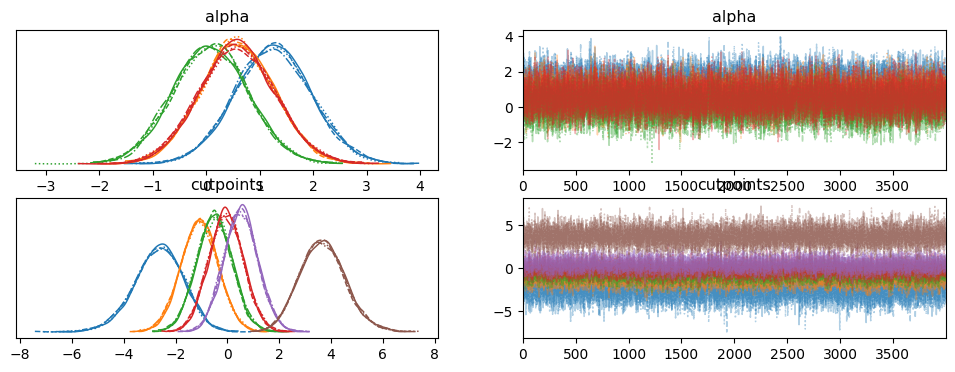

In [14]:
az.plot_trace(boxh1_trace, var_names=["alpha", "cutpoints"])

In [15]:
alpha_summary = az.summary(boxh1_trace, var_names="alpha")
alpha_summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[0.0]  1.248  0.715  -0.061    2.614      0.008    0.005    8882.0   
alpha[3.0]  0.584  0.690  -0.703    1.890      0.008    0.006    7539.0   
alpha[2.0]  0.079  0.700  -1.275    1.359      0.008    0.006    7630.0   
alpha[1.0]  0.582  0.708  -0.787    1.878      0.008    0.005    8339.0   

            ess_tail  r_hat  
alpha[0.0]   10899.0    1.0  
alpha[3.0]    9700.0    1.0  
alpha[2.0]   10461.0    1.0  
alpha[1.0]   10136.0    1.0

## H2. A player's perception of difficulty has an effect on its performance(score)


In this case we're using an ordinal variable to predict a score, which for Boxing can be seen as count data.



In [17]:
final_frames = logs_df[logs_df["game_name"]=="Boxing-v5"].groupby(["participant_id", "trial"])["frame"].idxmax()
grouped_box_df = logs_df.iloc[list(final_frames.values)]

box_score = grouped_box_df[["participant_id", "trial", "ram_18", "ram_19"]]
box_score

box_h2 = pd.merge(pxi_df_box, box_score, left_on=("participant_id", "trial"), right_on=("participant_id", "trial"))


X = box_h2["pxi_CH"].str.lower()

X =  pd.Categorical(
    X.values,
    categories=list(pxi_id_to_number.keys()),
    ordered=True,
)

y1 = box_h2["ram_18"]
y2 = box_h2["ram_18"] - box_h2["ram_19"]



In [29]:
with pm.Model() as mboxh2:
    beta = pm.Normal('beta', 0,0.5)
    delta = pm.Dirichlet("delta", np.repeat(5,6), shape=6)
    delta_i = tt.concatenate([tt.zeros(1), delta])
    
    CH = pm.Data("CH", X.codes)
    
    lambd = pm.Deterministic("lambd", pm.math.exp(beta*(tt.cumsum(delta_i)[CH])))

    # mu = pm.Deterministic("mu", beta*(tt.cumsum(delta_i)[CH]))
    
    # S = pm.Normal("S", mu=mu, observed=y2.values)
    S = pm.Poisson("S", mu=lambd, observed=y1.values)
    idata = pm.sample_prior_predictive(draws=50, random_seed=rng)
    
    

Sampling: [S, beta, delta]


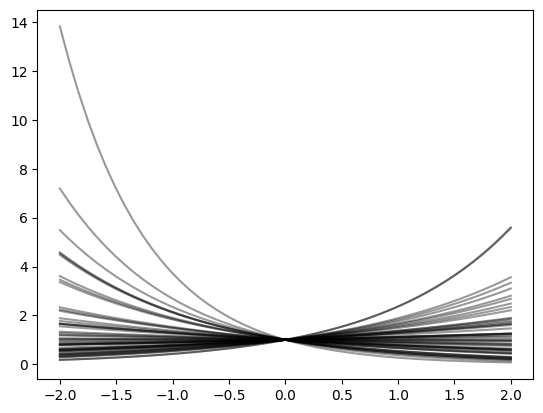

In [30]:
import xarray as xr

x_prior = xr.DataArray(np.linspace(-2, 2, 50), dims=["plot_dim"])
prior = idata.prior
y = np.exp(prior["beta"] * x_prior)

plt.plot(x_prior, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)
plt.show()

In [31]:
with mboxh2:
    idata.extend(pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, target_accept = 0.93, random_seed=rng, nuts_sampler="numpyro"))

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,5]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>]], dtype=object)

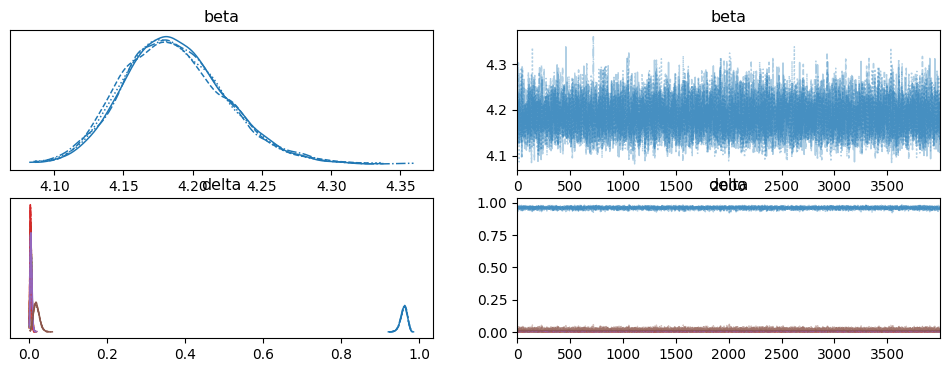

In [32]:
az.plot_trace(idata,var_names=["beta","delta"])

In [33]:
az.summary(idata,var_names=["beta", "delta"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta      4.187  0.037   4.119    4.256        0.0      0.0   10438.0   
delta[0]  0.961  0.008   0.945    0.977        0.0      0.0    9155.0   
delta[1]  0.005  0.002   0.001    0.009        0.0      0.0   12371.0   
delta[2]  0.005  0.002   0.001    0.009        0.0      0.0   12247.0   
delta[3]  0.004  0.002   0.001    0.008        0.0      0.0   10853.0   
delta[4]  0.005  0.002   0.001    0.009        0.0      0.0   11520.0   
delta[5]  0.019  0.008   0.006    0.034        0.0      0.0   10173.0   

          ess_tail  r_hat  
beta        8101.0    1.0  
delta[0]    9666.0    1.0  
delta[1]    9098.0    1.0  
delta[2]    7975.0    1.0  
delta[3]    8345.0    1.0  
delta[4]    8483.0    1.0  
delta[5]   10340.0    1.0

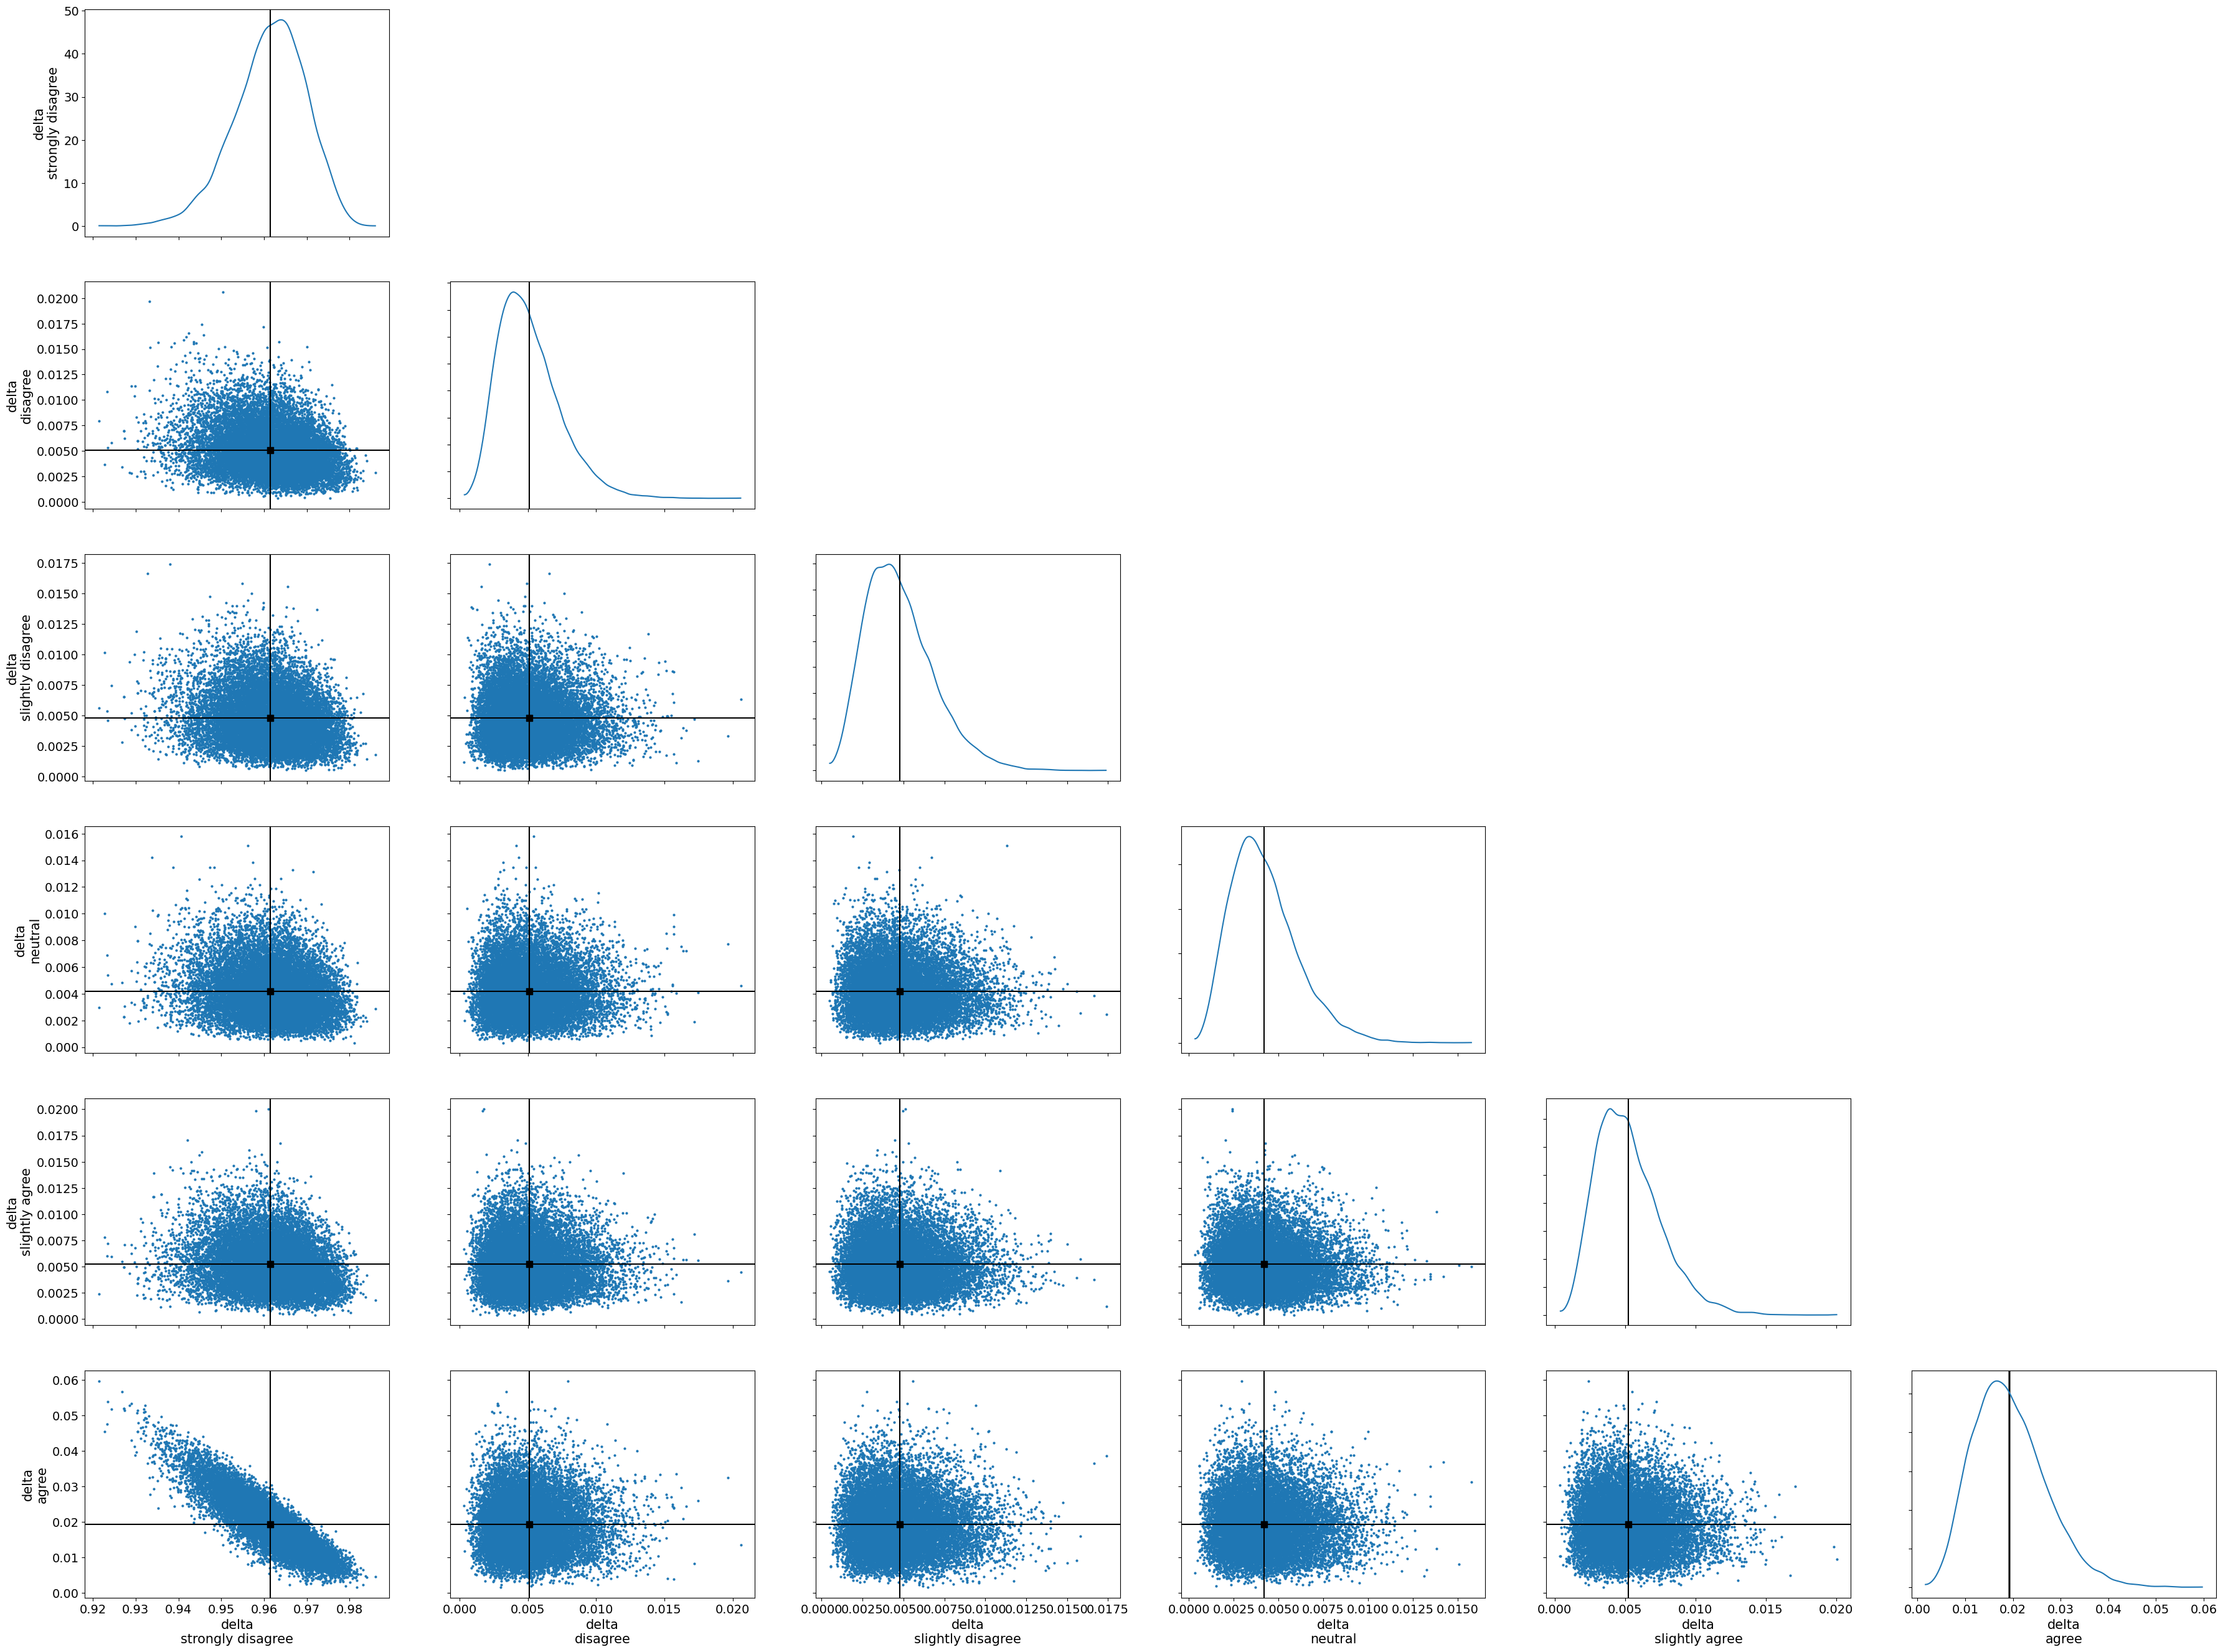

In [34]:
idata.posterior.coords["delta_dim_0"] = list(pxi_id_to_number.keys())[:-1]
pm.plot_pair(
idata,
var_names=["delta"],
marginals=True,
point_estimate="mean"
);

plt.show()

In [35]:
with mboxh2:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Sampling: [S]


Output()

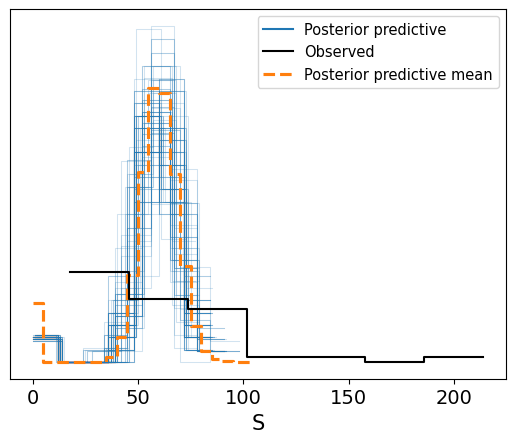

In [36]:
az.plot_ppc(idata, num_pp_samples=100);

Is the pre configured difficulty also a significant predictor of score?

In [ ]:
with pm.Model(coords={"difficulties": unique_diff}) as mboxh1_2:
    current_difficulty = pm.Data("difficulty", diff_id)
    
    alpha = pm.Normal("alpha", 0, 5, dims="difficulties")
    beta = pm.Normal("beta", 0,3, dims="difficulties")
    delta = pm.Dirichlet("delta", np.repeat(5,6), shape=6)
    delta_i = tt.concatenate([tt.zeros(1), delta])
    
    CH = pm.Data("CH", X.codes)
    
    lambd = pm.Deterministic("lambd", pm.math.exp(beta*(tt.cumsum(delta_i)[CH])))
    
    lambd = pm.Deterministic("lambd", pm.math.exp(alpha[current_difficulty]))
    

    
    y = pm.Poisson("y", mu=lambd, observed=y_ch.values)
    
    
    # boxh1_2_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro")
    



  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

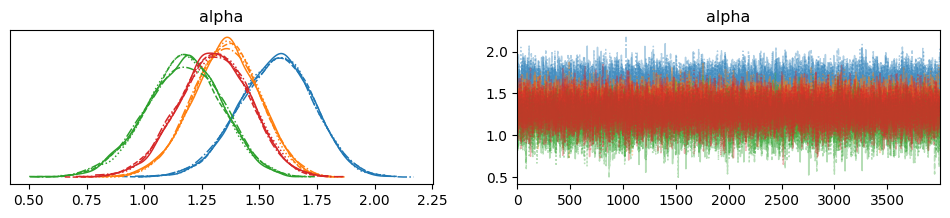

In [136]:
az.plot_trace(boxh1_2_trace, var_names=["alpha"])

In [137]:
az.summary(boxh1_2_trace, var_names="alpha")

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[0.0]  1.571  0.161   1.265    1.863      0.001    0.001   18691.0   
alpha[3.0]  1.353  0.146   1.081    1.629      0.001    0.001   17647.0   
alpha[2.0]  1.171  0.166   0.853    1.474      0.001    0.001   16574.0   
alpha[1.0]  1.304  0.156   1.015    1.593      0.001    0.001   19071.0   

            ess_tail  r_hat  
alpha[0.0]   12448.0    1.0  
alpha[3.0]   12014.0    1.0  
alpha[2.0]   10408.0    1.0  
alpha[1.0]   12496.0    1.0

Let's condition on the perceived difficulty

# Turmoil

In [22]:
pxi_df_turm = pxi_df[pxi_df["game_name"] == "Turmoil"].drop(columns="game_name")
pxi_df_turm.head()

participant_id  trial  mode  difficulty          pxi_AA             pxi_CH  \
2            P009    3.0   1.0         0.0  Strongly Agree     Slightly agree   
3            P013    2.0   1.0         0.0  Slightly agree     Slightly agree   
6            P015    3.0   2.0         0.0  Slightly agree              Agree   
9            P011    3.0   0.0         0.0  Slightly agree  slightly disagree   
13           P003    2.0   2.0         0.0        Disagree           Disagree   

            pxi_EC             pxi_GR          pxi_PF         pxi_AUT  \
2   Strongly Agree     Strongly Agree  Strongly Agree  Strongly Agree   
3   Slightly agree              Agree  Strongly Agree             NaN   
6            Agree     Slightly agree  Slightly agree  Slightly agree   
9   Strongly Agree     Strongly Agree           Agree  Slightly agree   
13  Slightly agree  slightly disagree        Disagree        Disagree   

              pxi_CUR         pxi_IMM         pxi_MAS            pxi_MEA  \
2      Strongly Agree  Strongly Agree  Strongly Agree     Strongly Agree   
3      Slightly agree  Slightly agree  Slightly agree  slightly disagree   
6             Neutral  Strongly Agree           Agree            Neutral   
9               Agree  Strongly Agree  Slightly agree              Agree   
13  slightly disagree           Agree        Disagree  Strongly disagree   

           pxi_ENJ        STIMES         TIMES  
2   Strongly Agree  1.746090e+12  1.746090e+12  
3   Slightly agree  1.746434e+12  1.746434e+12  
6            Agree  1.746528e+12  1.746528e+12  
9            Agree  1.746111e+12  1.746111e+12  
13        Disagree  1.745571e+12  1.745572e+12

In [23]:
diff_id, unique_diff = pd.factorize(pxi_df_turm["mode"])
trial_id, unique_trial = pd.factorize(pxi_df_turm["trial"])

In [24]:
y_ch = pxi_df_turm["pxi_CH"].str.lower().replace(pxi_id_to_number)


/tmp/ipykernel_15276/1504150703.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_ch = pxi_df_turm["pxi_CH"].str.lower().replace(pxi_id_to_number)


## H1: A game's difficulty configuration or current trial have an effect on on a player's perception of challenge

In [25]:
with pm.Model(coords={"difficulties": unique_diff, "trials": unique_trial}) as m_turmh1:
    current_difficulty = pm.Data("difficulty", diff_id)
    current_trial = pm.Data("trial", trial_id)
    
    alpha = pm.Normal("alpha", 0, 0.5, dims="difficulties")
    beta = pm.Normal("beta", 0, 0.5, dims="trials")
    sigma = pm.Exponential("sigma", 0.25)
    
    eta = pm.Deterministic("eta", alpha[current_difficulty] + beta[current_trial])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,5,5), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=y_ch.values - 1)
    
    turmh1_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro")
    
    

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

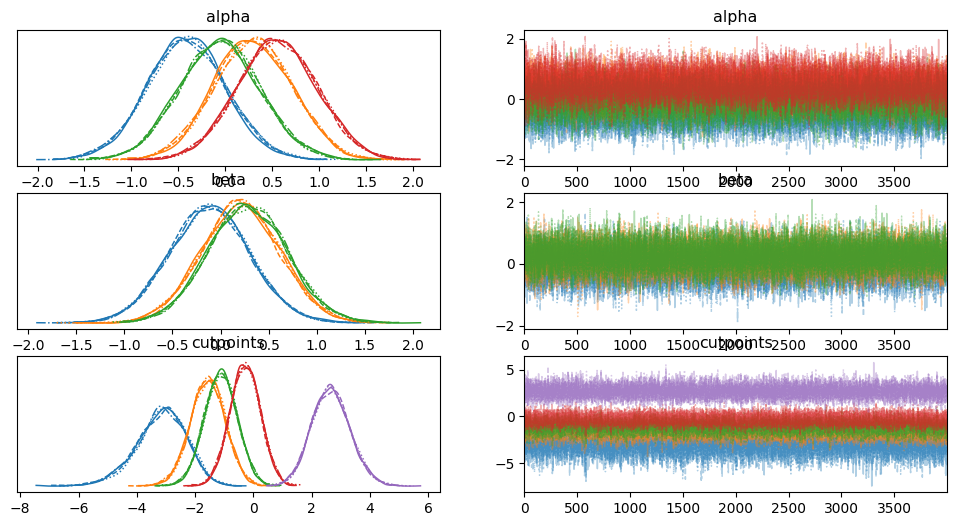

In [26]:
az.plot_trace(turmh1_trace, var_names=["alpha", "beta", "cutpoints"])

In [27]:
alpha_summary = az.summary(turmh1_trace, var_names="alpha")
alpha_summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[1.0] -0.413  0.420  -1.213    0.374      0.003    0.003   17498.0   
alpha[2.0]  0.296  0.418  -0.475    1.092      0.003    0.003   19492.0   
alpha[0.0] -0.060  0.427  -0.858    0.743      0.003    0.003   20265.0   
alpha[3.0]  0.551  0.421  -0.263    1.312      0.003    0.002   18402.0   

            ess_tail  r_hat  
alpha[1.0]   11859.0    1.0  
alpha[2.0]   12428.0    1.0  
alpha[0.0]   11874.0    1.0  
alpha[3.0]   11886.0    1.0

In [28]:
beta_summary = az.summary(turmh1_trace, var_names="beta")
beta_summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[3.0] -0.114  0.421  -0.912    0.669      0.003    0.003   17504.0   
beta[2.0]  0.210  0.408  -0.578    0.962      0.003    0.003   18363.0   
beta[1.0]  0.283  0.410  -0.513    1.030      0.003    0.003   17226.0   

           ess_tail  r_hat  
beta[3.0]   12349.0    1.0  
beta[2.0]   12387.0    1.0  
beta[1.0]   11863.0    1.0

## H2: A player's perception of difficulty has an effect on their performance score

In [93]:
final_frames = logs_df[logs_df["game_name"]=="Turmoil-v5"].groupby(["participant_id", "trial"])["frame"].idxmax()
grouped_turm_df = logs_df.iloc[list(final_frames.values)]

turm_score = grouped_turm_df[["participant_id", "trial", "ram_9", "ram_10"]]
turm_score
turm_h2 = pd.merge(pxi_df_turm, turm_score, left_on=("participant_id", "trial"), right_on=("participant_id", "trial"))


X = turm_h2["pxi_CH"].str.lower()

X =  pd.Categorical(
    X.values,
    categories=list(pxi_id_to_number.keys())[1:],
    ordered=True,
)


In [95]:
X.codes

array([3, 3, 4, 1, 0, 4, 1, 4, 4, 4, 2, 1, 4, 2, 5, 4, 0, 4, 1, 1, 4, 4,
       4, 3, 4, 4, 4, 5, 4, 5, 5, 4, 3, 5, 4, 4, 4, 3, 3, 4, 4, 4, 4],
      dtype=int8)

In [94]:
def bcd16_to_decimal(hi_byte: int, lo_byte: int) -> int:
    """
    Convert a 16-bit BCD score (two bytes) to a regular integer.
    
    Parameters:
        hi_byte (int): High BCD byte (tens and thousands).
        lo_byte (int): Low BCD byte (ones and hundreds).
    
    Returns:
        int: The decoded decimal score.
    """
    # Extract nibbles from high byte
    hi_tens = (hi_byte >> 4) & 0x0F
    hi_ones = hi_byte & 0x0F
    
    # Extract nibbles from low byte
    lo_tens = (lo_byte >> 4) & 0x0F
    lo_ones = lo_byte & 0x0F
    
    # Compute decimal value
    return hi_tens * 1000 + hi_ones * 100 + lo_tens * 10 + lo_ones

y1 = turm_h2.apply(lambda x: bcd16_to_decimal(x['ram_10'], x['ram_9']), 
                        axis=1)
y1

0     204
1     118
2     178
3     164
4     211
5      98
6     169
7     182
8      32
9      70
10    344
11    222
12    117
13     25
14    200
15    151
16    165
17    108
18    166
19     91
20    166
21    143
22    542
23    238
24    216
25    199
26    202
27    171
28     93
29    220
30    444
31     11
32    281
33    167
34    201
35    248
36    282
37    218
38    182
39    110
40    175
41    128
42    112
dtype: int64

In [118]:
with pm.Model() as mturmh2:
    beta = pm.Normal('beta', 0,0.5)
    delta = pm.Dirichlet("delta", np.repeat(5,5), shape=5)
    delta_i = tt.concatenate([tt.zeros(1), delta])
    
    CH = pm.Data("CH", X.codes)
    
    lambd = pm.Deterministic("lambd", pm.math.exp(beta*(tt.cumsum(delta_i)[CH])))

    # mu = pm.Deterministic("mu", beta*(tt.cumsum(delta_i)[CH]))
    
    # S = pm.Normal("S", mu=mu, observed=y2.values)
    S = pm.Poisson("S", mu=lambd, observed=y1.values)
    idata = pm.sample_prior_predictive(draws=50, random_seed=rng)
    # idata = pm.sample(4000,tune=2000, nuts_sampler="numpyro")
    
    

Sampling: [S, beta, delta]


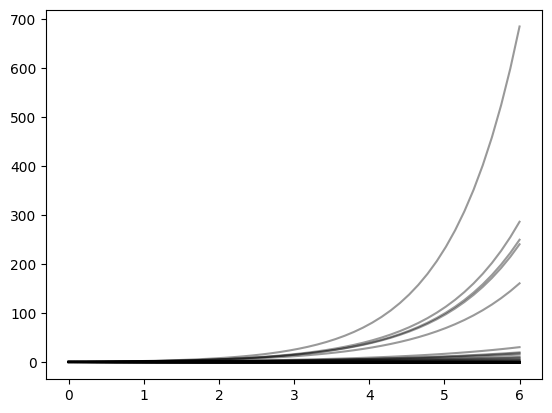

In [119]:
import xarray as xr

x_prior = xr.DataArray(np.linspace(0, 6, 50), dims=["plot_dim"])
prior = idata.prior
y = np.exp(prior["beta"] * x_prior)

plt.plot(x_prior, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)
plt.show()

In [120]:
with mturmh2:
    idata.extend(pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, target_accept = 0.93, random_seed=rng, nuts_sampler="numpyro"))

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,4]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>]], dtype=object)

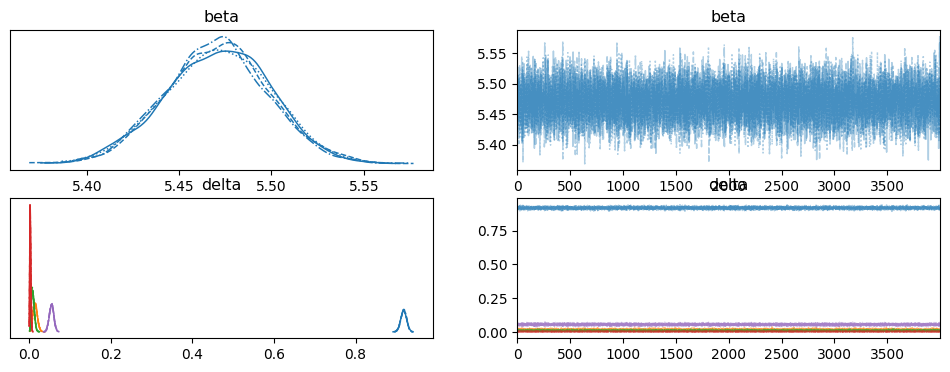

In [121]:
az.plot_trace(idata,var_names=["beta","delta"])

In [122]:
az.summary(idata,var_names=["beta", "delta"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta      5.471  0.028   5.417    5.524        0.0      0.0   11682.0   
delta[0]  0.918  0.007   0.904    0.931        0.0      0.0   12315.0   
delta[1]  0.015  0.005   0.006    0.025        0.0      0.0    9429.0   
delta[2]  0.009  0.004   0.003    0.016        0.0      0.0    8326.0   
delta[3]  0.003  0.001   0.001    0.006        0.0      0.0    8303.0   
delta[4]  0.055  0.005   0.045    0.065        0.0      0.0   12433.0   

          ess_tail  r_hat  
beta       10301.0    1.0  
delta[0]   11246.0    1.0  
delta[1]    6729.0    1.0  
delta[2]    7076.0    1.0  
delta[3]    7429.0    1.0  
delta[4]   10761.0    1.0

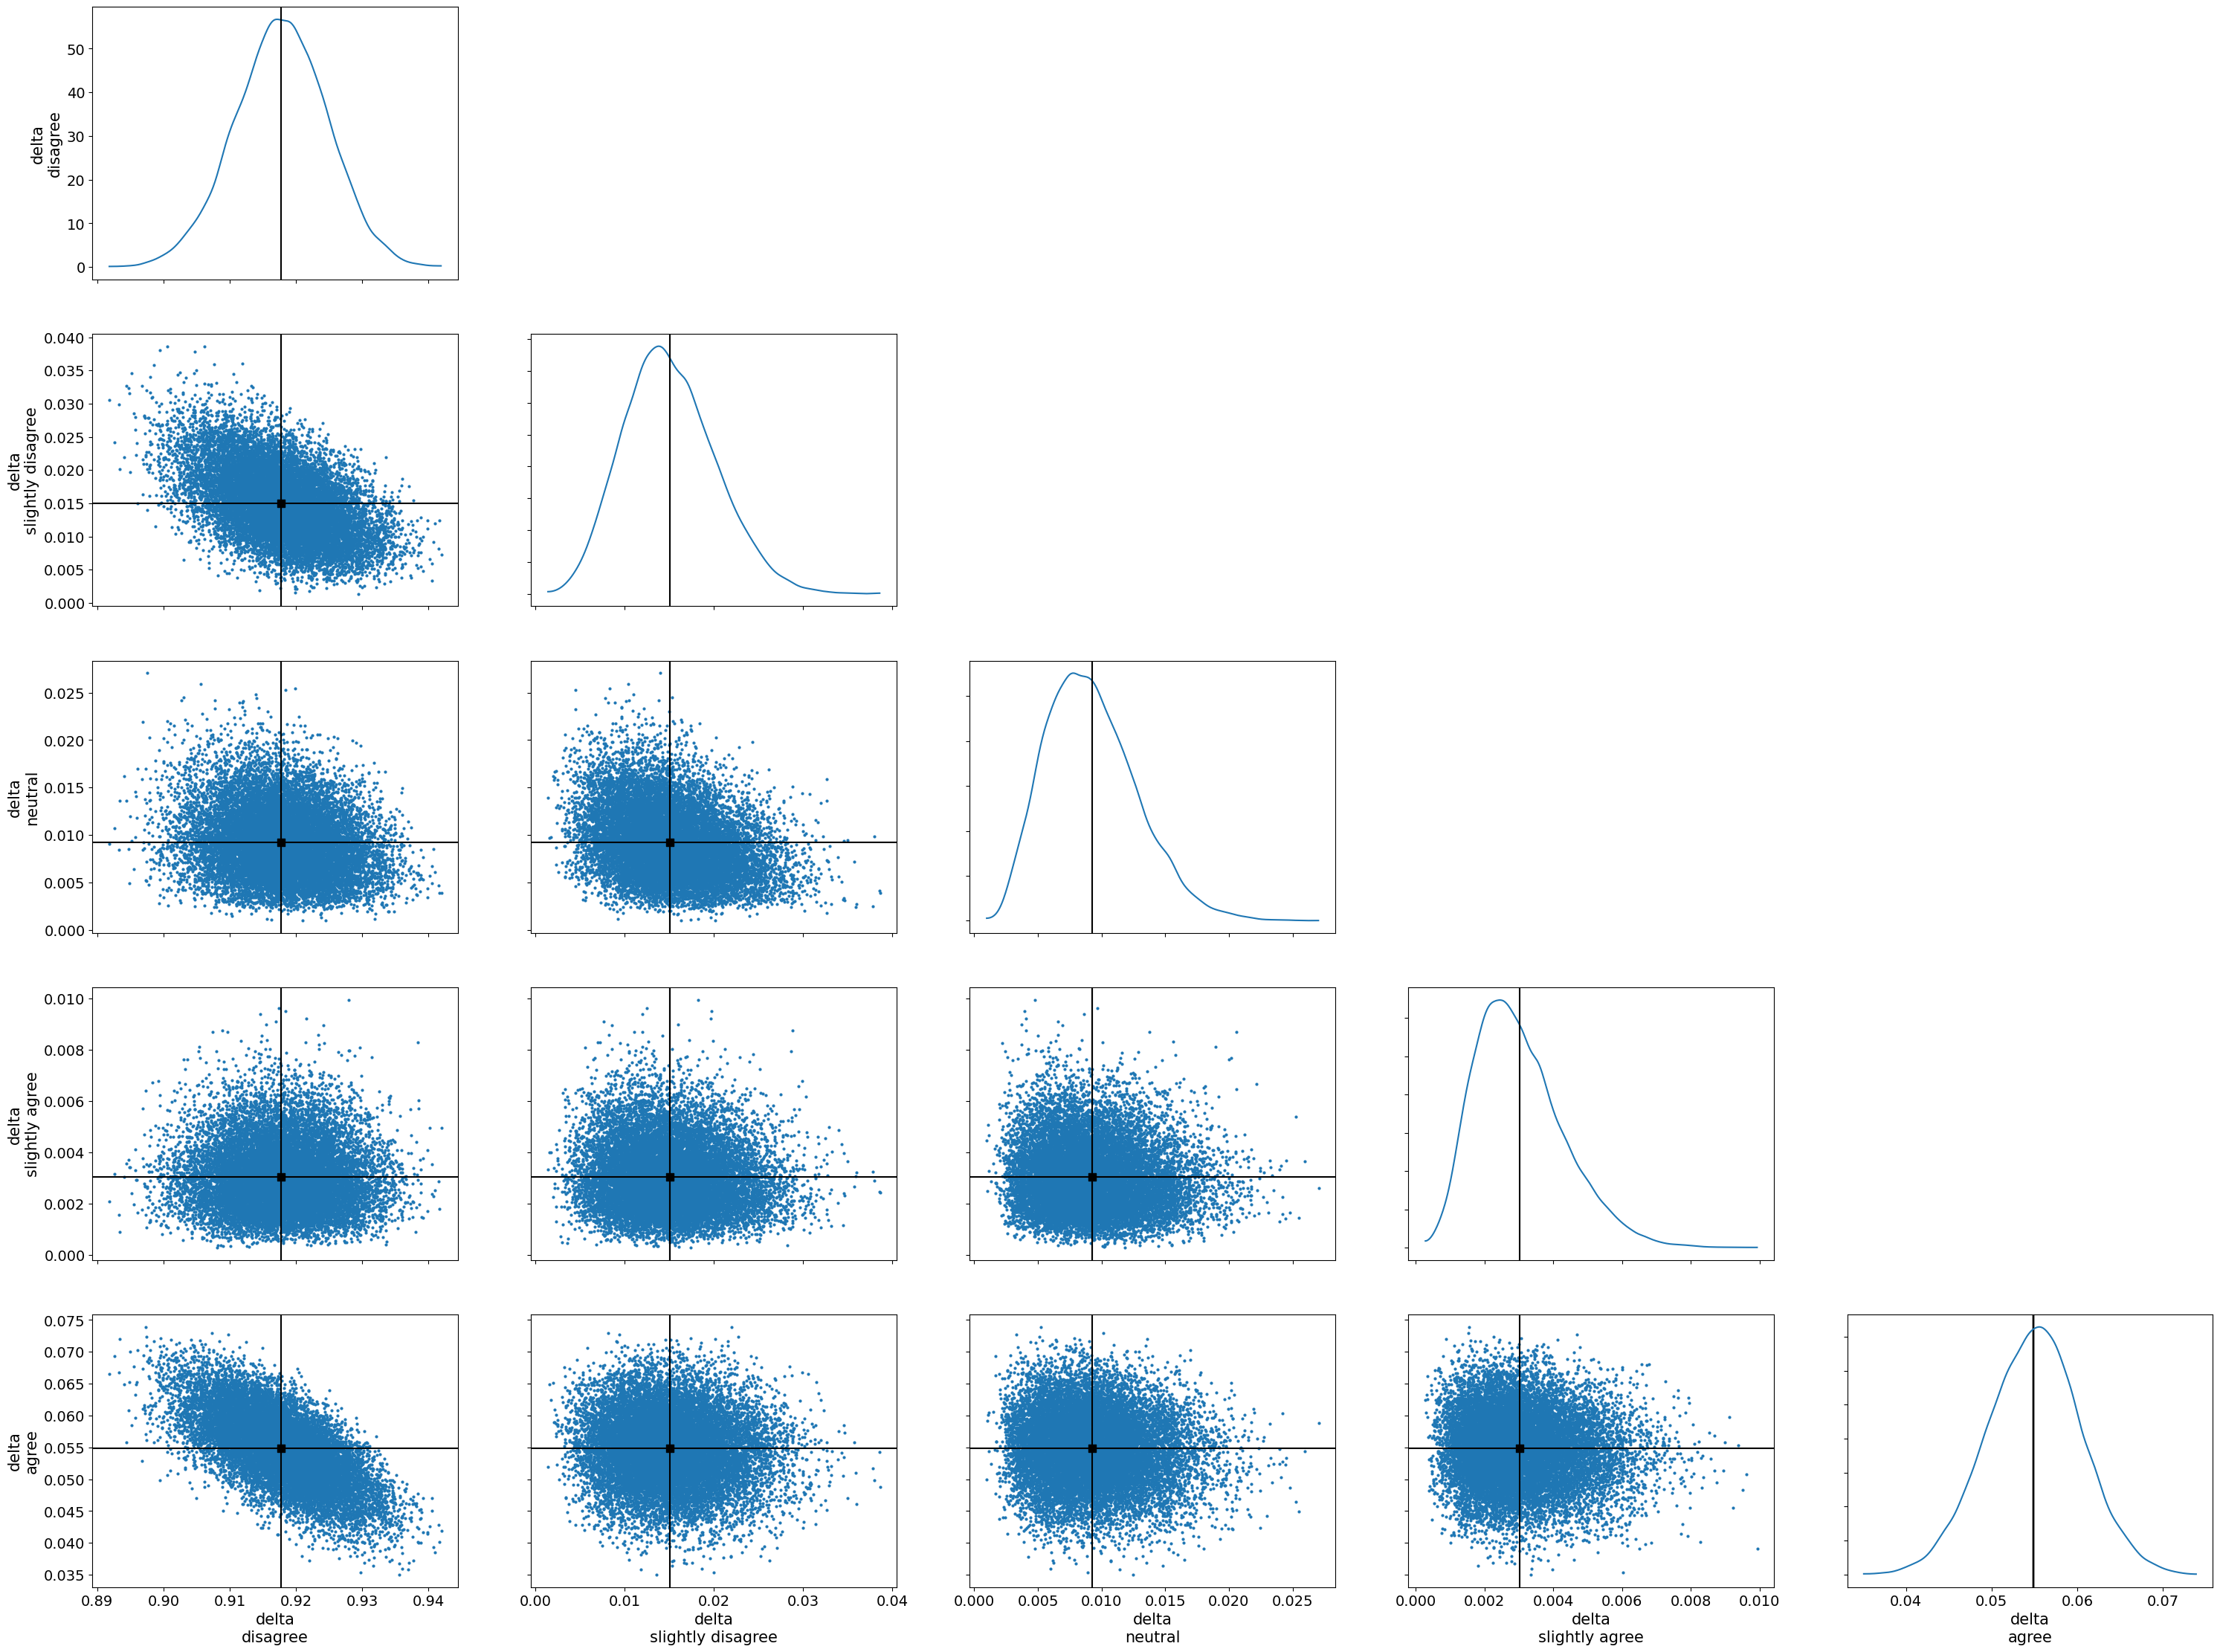

In [123]:
idata.posterior.coords["delta_dim_0"] = X.categories[:-1]
pm.plot_pair(
idata,
var_names=["delta"],
marginals=True,
point_estimate="mean"
);

In [124]:
with mturmh2:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Sampling: [S]


Output()

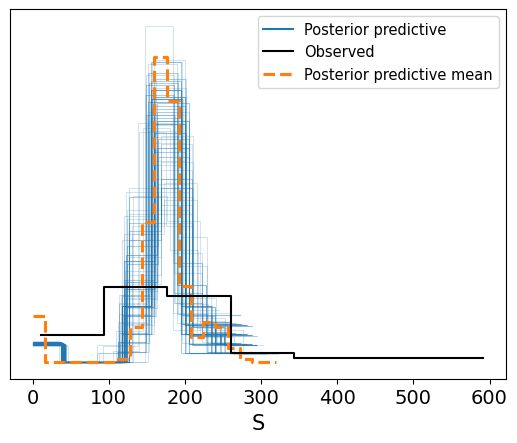

In [125]:
az.plot_ppc(idata, num_pp_samples=100);

# Word Zapper

In [6]:
pxi_df_word = pxi_df[pxi_df["game_name"] == "WordZapper"].drop(columns="game_name")
pxi_df_word.head()

participant_id  trial  mode  difficulty          pxi_AA             pxi_CH  \
0            P001    1.0   2.0         0.0  Slightly agree              Agree   
3            P001    2.0   1.0         3.0  Slightly agree              Agree   
7            P002    1.0   0.0         0.0  Slightly agree            Neutral   
11           P002    2.0   0.0         2.0  Slightly agree           Disagree   
13           P002    3.0   3.0         1.0  Slightly agree  slightly disagree   

            pxi_EC             pxi_GR             pxi_PF            pxi_AUT  \
0   Slightly agree           Disagree           Disagree              Agree   
3   Slightly agree           Disagree  slightly disagree  slightly disagree   
7         Disagree  Strongly disagree     Slightly agree           Disagree   
11           Agree     Slightly agree     Strongly Agree            Neutral   
13           Agree  Strongly disagree     Slightly agree  slightly disagree   

           pxi_CUR         pxi_IMM         pxi_MAS         pxi_MEA  \
0            Agree  Strongly Agree        Disagree         Neutral   
3   Slightly agree  Strongly Agree        Disagree         Neutral   
7            Agree  Strongly Agree        Disagree        Disagree   
11           Agree  Strongly Agree  Strongly Agree  Slightly agree   
13           Agree  Strongly Agree        Disagree         Neutral   

              pxi_ENJ        STIMES         TIMES  
0               Agree  1.744629e+12  1.744629e+12  
3             Neutral  1.744629e+12  1.744630e+12  
7   slightly disagree  1.745490e+12  1.745490e+12  
11     Slightly agree  1.745490e+12  1.745491e+12  
13           Disagree  1.745491e+12  1.745491e+12

In [7]:
diff_id, unique_diff = pd.factorize(pxi_df_word["mode"])
trial_id, unique_trial = pd.factorize(pxi_df_word["trial"])

In [8]:
y_ch = pxi_df_word["pxi_CH"].str.lower().replace(pxi_id_to_number)
y_mas = pxi_df_word["pxi_MAS"].str.lower().replace(pxi_id_to_number)
y_imm = pxi_df_word["pxi_IMM"].str.lower().replace(pxi_id_to_number)


/tmp/ipykernel_8712/3241219151.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_ch = pxi_df_word["pxi_CH"].str.lower().replace(pxi_id_to_number)
/tmp/ipykernel_8712/3241219151.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_mas = pxi_df_word["pxi_MAS"].str.lower().replace(pxi_id_to_number)
/tmp/ipykernel_8712/3241219151.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to 

## H1: A game's difficulty configuration or current trial have an effect on on a player's perception of challenge

In [11]:
y_ch.unique()

array([5, 3, 1, 2, 4, 6, 0])

In [16]:
with pm.Model(coords={"difficulties": unique_diff, "trials": unique_trial}) as m_wordh1:
    current_difficulty = pm.Data("difficulty", diff_id)
    current_trial = pm.Data("trial", trial_id)
    
    alpha = pm.Normal("alpha", 0, 0.5, dims="difficulties")
    beta = pm.Normal("beta", 0, 0.5, dims="trials")
    sigma = pm.Exponential("sigma", 0.25)
    
    eta = pm.Deterministic("eta", alpha[current_difficulty] + beta[current_trial]) # 
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=y_ch.values)
    
    wordh1_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng)
    
    

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, cutpoints]


Output()

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/pytensor/compile/function/types.py:992: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 13 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

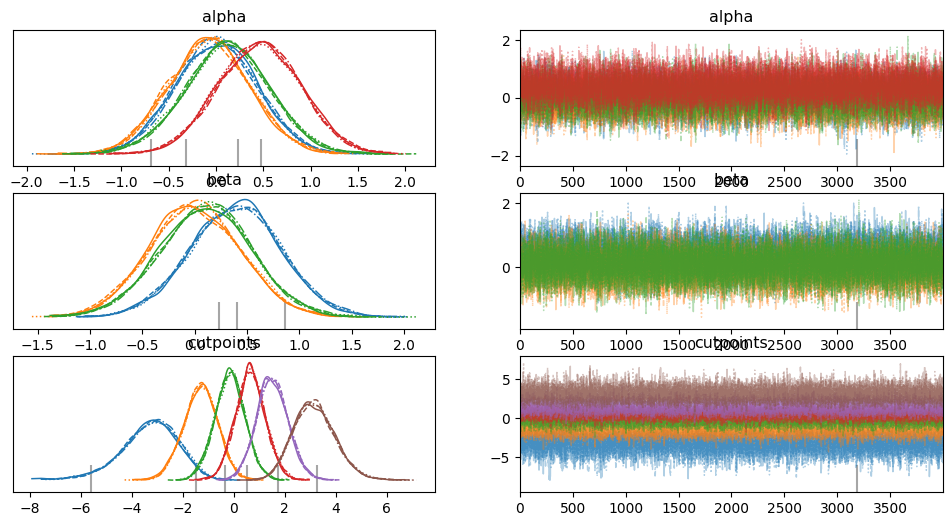

In [17]:
az.plot_trace(wordh1_trace, var_names=["alpha", "beta", "cutpoints"])

In [19]:
alpha_summary = az.summary(wordh1_trace, var_names="alpha")
alpha_summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[2.0]  0.004  0.431  -0.793    0.818      0.003    0.004   20375.0   
alpha[1.0] -0.071  0.427  -0.859    0.740      0.003    0.004   19663.0   
alpha[0.0]  0.123  0.449  -0.718    0.975      0.003    0.004   17110.0   
alpha[3.0]  0.457  0.435  -0.362    1.257      0.003    0.003   17425.0   

            ess_tail  r_hat  
alpha[2.0]   11137.0    1.0  
alpha[1.0]   11672.0    1.0  
alpha[0.0]    9709.0    1.0  
alpha[3.0]   10232.0    1.0

In [20]:
beta_summary = az.summary(wordh1_trace, var_names="beta")
beta_summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[1.0]  0.392  0.433  -0.450    1.182      0.003    0.003   19044.0   
beta[2.0]  0.000  0.433  -0.827    0.797      0.003    0.003   16885.0   
beta[3.0]  0.108  0.438  -0.723    0.928      0.003    0.004   19307.0   

           ess_tail  r_hat  
beta[1.0]   11295.0    1.0  
beta[2.0]   11617.0    1.0  
beta[3.0]   10638.0    1.0

#### interaction model

In [22]:
with pm.Model(coords={"trials": unique_trial, "difficulties": unique_diff}) as m_wordh2_int:
    current_trial = pm.Data("trial", trial_id)
    current_difficulty = pm.Data("difficulty", diff_id)
    
    beta = pm.Normal("beta", 0, 0.5, dims="trials")
    alpha = pm.Normal("alpha", 0, 0.5, dims="difficulties")
    gamma = pm.Normal("gamma", 0, 0.5, dims=("difficulties", "trials"))
    sigma = pm.Exponential("sigma", 0.25)
    
    eta = pm.Deterministic("eta", alpha[current_difficulty] + beta[current_trial] + gamma[current_difficulty, current_trial])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedProbit("y", eta=eta, cutpoints=cutpoints, observed=y_ch.values)
    
    wordh2_int_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, gamma, sigma, cutpoints]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 21 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

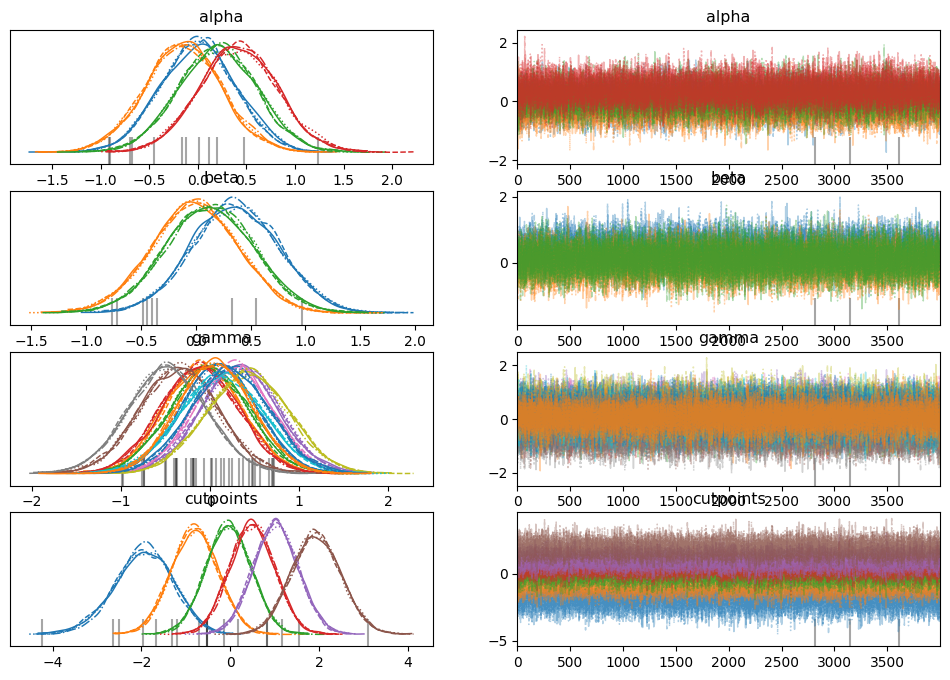

In [23]:
az.plot_trace(wordh2_int_trace, var_names=["alpha", "beta", "gamma", "cutpoints"])

In [24]:
alpha_summary_h3 = az.summary(wordh2_int_trace, var_names="alpha")
alpha_summary_h3

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[2.0]  0.003  0.389  -0.719    0.736      0.003    0.003   15874.0   
alpha[1.0] -0.152  0.395  -0.910    0.589      0.003    0.003   16477.0   
alpha[0.0]  0.203  0.405  -0.556    0.967      0.003    0.003   18118.0   
alpha[3.0]  0.417  0.402  -0.349    1.168      0.003    0.002   17548.0   

            ess_tail  r_hat  
alpha[2.0]   12935.0    1.0  
alpha[1.0]   11778.0    1.0  
alpha[0.0]   12445.0    1.0  
alpha[3.0]   12229.0    1.0

In [25]:
beta_summary_h3 = az.summary(wordh2_int_trace, var_names="beta")
beta_summary_h3

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[1.0]  0.364  0.398  -0.375    1.122      0.003    0.003   16087.0   
beta[2.0] -0.006  0.394  -0.761    0.722      0.003    0.003   15362.0   
beta[3.0]  0.124  0.402  -0.625    0.888      0.003    0.003   14668.0   

           ess_tail  r_hat  
beta[1.0]   12605.0    1.0  
beta[2.0]   12611.0    1.0  
beta[3.0]   11937.0    1.0

In [26]:
gamma_summary_h3 = az.summary(wordh2_int_trace, var_names="gamma")
gamma_summary_h3

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
gamma[2.0, 1.0]  0.093  0.427  -0.696    0.899      0.003    0.003   20948.0   
gamma[2.0, 2.0] -0.080  0.428  -0.876    0.720      0.003    0.004   21903.0   
gamma[2.0, 3.0] -0.015  0.440  -0.823    0.820      0.003    0.004   23769.0   
gamma[1.0, 1.0] -0.121  0.433  -0.929    0.691      0.003    0.003   22254.0   
gamma[1.0, 2.0]  0.333  0.440  -0.520    1.142      0.003    0.003   21993.0   
gamma[1.0, 3.0] -0.355  0.441  -1.171    0.497      0.003    0.003   19888.0   
gamma[0.0, 1.0]  0.255  0.431  -0.565    1.057      0.003    0.003   23699.0   
gamma[0.0, 2.0] -0.479  0.442  -1.297    0.364      0.003    0.003   22189.0   
gamma[0.0, 3.0]  0.420  0.460  -0.446    1.270      0.003    0.003   21970.0   
gamma[3.0, 1.0]  0.134  0.473  -0.725    1.055      0.003    0.004   23581.0   
gamma[3.0, 2.0]  0.220  0.443  -0.645    1.024      0.003    0.003   21873.0   
gamma[3.0, 3.0]  0.056  0.418  -0.726    0.840      0.003    0.003   20316.0   

                 ess_tail  r_hat  
gamma[2.0, 1.0]   12210.0    1.0  
gamma[2.0, 2.0]   11859.0    1.0  
gamma[2.0, 3.0]   11539.0    1.0  
gamma[1.0, 1.0]   11210.0    1.0  
gamma[1.0, 2.0]   11442.0    1.0  
gamma[1.0, 3.0]   11613.0    1.0  
gamma[0.0, 1.0]   12533.0    1.0  
gamma[0.0, 2.0]   12049.0    1.0  
gamma[0.0, 3.0]   12055.0    1.0  
gamma[3.0, 1.0]   11318.0    1.0  
gamma[3.0, 2.0]   11455.0    1.0  
gamma[3.0, 3.0]   11096.0    1.0